# COMP4211 Programming Assignment 3

**Name: FONG, Ho Yin**  
**SID: 20599045**

### 4.3.1 Dataset and Dataloader
First, you are required to use the train test split in scikit-learn to split the train.csv data into a training set and a validation set. The validation set should contain 2,000 examples (1,000 for each class) for holdout validation. You should set random state to be 4211 for
reproducibility.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import numpy as np

PATH = './'

train_df = pd.read_csv(PATH + 'train.csv')

# Split training dataframe to two classes, then use train_test_split to obtain training set and validation set
X0 = train_df[train_df.label == 0]['text']
y0 = train_df[train_df.label == 0]['label']
X1 = train_df[train_df.label == 1]['text']
y1 = train_df[train_df.label == 1]['label']

X_train0, X_val0, y_train0, y_val0 = train_test_split(X0, y0, test_size = 1000, random_state = 4211)
X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, test_size = 1000, random_state = 4211)
X_train = pd.concat([X_train0, X_train1], axis = 0)
y_train = pd.concat([y_train0, y_train1], axis = 0)
X_val = pd.concat([X_val0, X_val1], axis = 0)
y_val = pd.concat([y_val0, y_val1], axis = 0)

train_df = pd.concat([X_train, y_train], axis = 1)
valid_df = pd.concat([X_val, y_val], axis = 1)

The next step is to build a TabularDataset class. A TabularDataset object loads the train dataset and valid dataset with properly defined fields for the label data and the text data. The vocabulary should only include the words with a frequency of at least 2. (Hint: the vocabulary used for training, validation, and prediction should only be built using the training data.)

**[Q1]** Report the number of out-of-vocabulary (OOV) words in your training set and validation set, respectively. How does the torchtext library tackle the OOV words?

In [2]:
from torchtext.data import Field, TabularDataset, BucketIterator, Example
from nltk import word_tokenize

txt_field = Field(tokenize=word_tokenize, lower=True, batch_first=True, include_lengths=True)
label_field = Field(sequential=False, use_vocab=False, batch_first=True)

train_df.to_csv('./train_df.csv', header=True, index=False)
valid_df.to_csv('./valid_df.csv', header=True, index=False)
train, valid = TabularDataset.splits(path=PATH, train='train_df.csv', test='valid_df.csv',format='csv', 
                                     fields=[('text', txt_field), ('label', label_field)], skip_header=True)

txt_field.build_vocab(train, min_freq=2) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iter, valid_iter = BucketIterator.splits((train, valid), batch_size=64, sort_key=lambda x:len(x.text), sort_within_batch=True, device=device)

# Caculating Out-Of-Vocabulary words for training set and validation set
train_OOVcount = 0
for example in train.examples:
    for word in vars(example)['text']:
        if (txt_field.vocab.freqs[word] < 2):
            train_OOVcount += 1
print("Number of OOV words in training set: " + str(train_OOVcount))

valid_OOVcount = 0
for example in valid.examples:
    for word in vars(example)['text']:
        if (txt_field.vocab.freqs[word] < 2):
            valid_OOVcount += 1          
print("Number of OOV words in validation set: " + str(valid_OOVcount))

Number of OOV words in training set: 8633
Number of OOV words in validation set: 2966


### 4.3.2 RNN Baseline Model
An RNN model takes a sequence of words as input and produces the class probabilities as output. Here, you first build a baseline RNN model with the following settings:

**[Q2]** “Print” the model architecture and the number of trainable parameters for the baseline model and include them in the written report.

In [3]:
import torch.nn as nn
from torchsummaryX import summary

class Text_RNN(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Text_RNN, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim) 
        self.rnn = nn.RNN(
                input_size = embedding_dim,
                hidden_size = n_hidden,
                num_layers = n_layers,
                dropout = dropout,  
                batch_first = True
        )
        self.linear = nn.Linear(n_hidden, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, txt, txt_len):
        txt_emb = self.emb(txt)  #batch_size, max_sent_len, embedding_dim
        packed_embedded = nn.utils.rnn.pack_padded_sequence(txt_emb, txt_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        output = self.sigmoid(self.linear(outputs))
        output = torch.mean(output, 1)
        return output
    
model = Text_RNN(txt_field.vocab.__len__(), embedding_dim=50, n_hidden=64, n_layers=1, dropout=.1).cuda()
summary(model, torch.zeros((64,14), dtype=torch.int64).cuda(), torch.ones((64), dtype=torch.int64)*14)

C:\Users\User\anaconda3\envs\comp4211\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


          Kernel Shape  Output Shape  Params Mult-Adds
Layer                                                 
0_emb       [50, 7960]  [64, 14, 50]  398.0k    398.0k
1_rnn                -     [896, 64]  7.424k    7.296k
2_linear       [64, 1]   [64, 14, 1]    65.0      64.0
3_sigmoid            -   [64, 14, 1]       -         -
---------------------------------------------------------
                        Totals
Total params          405.489k
Trainable params      405.489k
Non-trainable params       0.0
Mult-Adds              405.36k


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_emb,"[50, 7960]","[64, 14, 50]",398000.0,398000.0
1_rnn,-,"[896, 64]",7424.0,7296.0
2_linear,"[64, 1]","[64, 14, 1]",65.0,64.0
3_sigmoid,-,"[64, 14, 1]",NaN,NaN


### 4.3.3 Training and Validation
Since this is a binary classification task, you may use BCELoss or BCEWithLogitsLoss provided by PyTorch. You should classify the example to real news if the predicted probability is at least 0.5, and to fake news otherwise. For optimization, you should use the default setting of the Adam optimizer with a batch size of 64. During model training, you are required to plot the training and validation losses of each epoch for 15 epochs in one plot using matplotlib (this setting is also applicable to the subsequent plotting of all the loss curves for this assignment).3 You may reuse the model training results in the early questions for the plotting and model comparison in the later questions. It is useful for you to save the best model checkpoint (the model checkpoint with the highest validation accuracy) for later parts.

**[Q3]** Paste the screenshot of the plot and report the best validation accuracy of the baseline model

In [4]:
def save_checkpoint(save_path, model, optimizer, val_acc):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_acc': val_acc}

    torch.save(state_dict, save_path)
    print(f'Model saved to {save_path}')

def load_checkpoint(save_path, model, optimizer):
    save_path = save_path 
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_acc = state_dict['val_acc']
    print(f'Model loaded from {save_path}, with val accuracy: {val_acc}')
    return val_acc


def TRAIN(model, train_loader, valid_loader,  num_epochs, criterion, optimizer, valid_acc, device, save_name):
    
    if valid_acc==None:
        best_valid_acc = float("-inf")  
    else: 
        best_valid_acc=valid_acc
        print('Resume training')
    
    model.to(device)
    
    train_loss_list, valid_loss_list = [], [] 
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        for i, batch in enumerate(train_loader):
            '''Training of the model'''
            # Forward pass
            text, text_len = batch.text
            output = model(text, text_len.to('cpu'))
            labels = batch.label.unsqueeze(1).type(torch.FloatTensor).to(device)
            loss = criterion(output, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_loss_list.append(train_loss)

        with torch.no_grad():
            model.eval()
            running_loss = 0.0
            running_corrects = 0
            for i, batch in enumerate(valid_loader):
                # Forward pass
                text, text_len = batch.text
                output = model(text, text_len.to('cpu'))
                labels = batch.label.unsqueeze(1).type(torch.FloatTensor).to(device)
                loss = criterion(output, labels)

                running_loss += loss.item()
                
                preds = (output >= 0.5)
                running_corrects += torch.sum(preds == labels.data)

            valid_loss = running_loss / len(valid_loader)
            valid_acc = running_corrects / float(len(valid_loader.dataset))
            valid_loss_list.append(valid_loss)

            print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}, Valid Accuracy: {:.4f}' 
                  .format(epoch+1, num_epochs, train_loss, valid_loss, valid_acc))

            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc
                save_checkpoint(save_name, model, optimizer, best_valid_acc)
                    
    print('Finished Training')
    return train_loss_list, valid_loss_list

In [5]:
from torch.optim import Adam

n_epochs = 15
val_acc = None
save_name = 'rnn_model'
criterion = nn.BCELoss()
optimizer = Adam(model.parameters())

#start training
train_loss_list, valid_loss_list = TRAIN(model, train_iter, valid_iter,  n_epochs, criterion, optimizer, val_acc, device, save_name)

Epoch [1/15], Train Loss: 0.4768, Valid Loss: 0.7450, Valid Accuracy: 0.5565
Model saved to rnn_model
Epoch [2/15], Train Loss: 0.4075, Valid Loss: 0.7238, Valid Accuracy: 0.5980
Model saved to rnn_model
Epoch [3/15], Train Loss: 0.3569, Valid Loss: 0.6303, Valid Accuracy: 0.6680
Model saved to rnn_model
Epoch [4/15], Train Loss: 0.3128, Valid Loss: 0.6133, Valid Accuracy: 0.6835
Model saved to rnn_model
Epoch [5/15], Train Loss: 0.2772, Valid Loss: 0.6541, Valid Accuracy: 0.7065
Model saved to rnn_model
Epoch [6/15], Train Loss: 0.2499, Valid Loss: 0.6490, Valid Accuracy: 0.6975
Epoch [7/15], Train Loss: 0.2252, Valid Loss: 0.6173, Valid Accuracy: 0.7170
Model saved to rnn_model
Epoch [8/15], Train Loss: 0.2012, Valid Loss: 0.6113, Valid Accuracy: 0.7340
Model saved to rnn_model
Epoch [9/15], Train Loss: 0.1841, Valid Loss: 0.5949, Valid Accuracy: 0.7455
Model saved to rnn_model
Epoch [10/15], Train Loss: 0.1649, Valid Loss: 0.6485, Valid Accuracy: 0.7355
Epoch [11/15], Train Loss: 0.

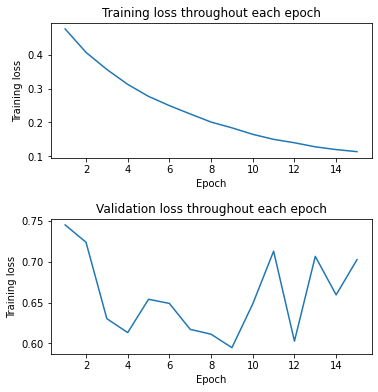

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1,figsize=(6,6))
fig.tight_layout(pad = 4.0)

x = range(1,16)

ax[0].plot(x, train_loss_list)
ax[0].set_title('Training loss throughout each epoch')  
ax[0].set_ylabel('Training loss')
ax[0].set_xlabel('Epoch')
ax[1].plot(x, valid_loss_list)
ax[1].set_title('Validation loss throughout each epoch')
ax[1].set_ylabel('Training loss')
ax[1].set_xlabel('Epoch') 

plt.show()

### 4.3.4 Empirical Study

#### Different RNN Settings

In this section, you need to build three models in addition to the baseline model. These three models are variants of the baseline model and are used to compare the performance of different RNN settings. You should only change the settings indicated in Table 3 and keep the other
settings the same as the baseline model.

**Model Description**: Model 1 and model 2 replace the baseline vanilla RNN cell with GRU and LSTM cells, respectively. Model 3 uses bidirectional LSTM. ‘Bidirectional’ here means that the sequential relationship of the sequences is modeled in both the forward and backward directions. This can be set in the parameters of nn.LSTM.

**[Q4]** List two advantages of using GRU and LSTM when compared to the baseline RNN model.

In [7]:
class Text_RNN_Var1(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Text_RNN_Var1, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim) 
        self.rnn = nn.GRU(                     # GRU, non-bi-directional
                input_size = embedding_dim,
                hidden_size = n_hidden,
                num_layers = n_layers,
                batch_first = True,
                dropout = dropout,
                bidirectional = False
        )
        self.linear = nn.Linear(n_hidden, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, txt, txt_len):
        txt_emb = self.emb(txt)  #batch_size, max_sent_len, embedding_dim
        packed_embedded = nn.utils.rnn.pack_padded_sequence(txt_emb, txt_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        output = self.sigmoid(self.linear(outputs))
        output = torch.mean(output, 1)
        return output

class Text_RNN_Var2(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Text_RNN_Var2, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim) 
        self.rnn = nn.LSTM(                     # LSTM, non-bi-directional
                input_size = embedding_dim,
                hidden_size = n_hidden,
                num_layers = n_layers,
                batch_first = True,
                dropout = dropout,
                bidirectional = False
        )
        self.linear = nn.Linear(n_hidden, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, txt, txt_len):
        txt_emb = self.emb(txt)  
        packed_embedded = nn.utils.rnn.pack_padded_sequence(txt_emb, txt_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        output = self.sigmoid(self.linear(outputs))
        output = torch.mean(output, 1)
        return output

class Text_RNN_Var3(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Text_RNN_Var3, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim) 
        self.rnn = nn.LSTM(                       # LSTM, bi-directional
                input_size = embedding_dim,
                hidden_size = n_hidden,
                num_layers = n_layers,
                batch_first = True,
                dropout = dropout,
                bidirectional = True
        )
        self.pool = nn.AvgPool1d(kernel_size=2)    # Transforming bi-directional outputs
        self.linear = nn.Linear(n_hidden, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, txt, txt_len):
        txt_emb = self.emb(txt)  
        packed_embedded = nn.utils.rnn.pack_padded_sequence(txt_emb, txt_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        outputs = self.pool(outputs)
        output = self.sigmoid(self.linear(outputs))
        output = torch.mean(output, 1)
        return output
    

model1 = Text_RNN_Var1(txt_field.vocab.__len__(), embedding_dim=50, n_hidden=64, n_layers=1, dropout=.1).cuda()
model2 = Text_RNN_Var2(txt_field.vocab.__len__(), embedding_dim=50, n_hidden=64, n_layers=1, dropout=.1).cuda()
model3 = Text_RNN_Var3(txt_field.vocab.__len__(), embedding_dim=50, n_hidden=64, n_layers=1, dropout=.1).cuda()

n_epochs = 15
val_acc = None
criterion = nn.BCELoss()

print("Training Model 1 (First variant):")
save_name = 'rnn_model1'
optimizer = Adam(model1.parameters())
train_loss_list1, valid_loss_list1 = TRAIN(model1, train_iter, valid_iter,  n_epochs, criterion, optimizer, val_acc, device, save_name)
print("\n\nTraining Model 2 (Second variant):")
save_name = 'rnn_model2'
optimizer = Adam(model2.parameters())
train_loss_list2, valid_loss_list2 = TRAIN(model2, train_iter, valid_iter,  n_epochs, criterion, optimizer, val_acc, device, save_name)
print("\n\nTraining Model 3 (Third variant):")
save_name = 'rnn_model3'
optimizer = Adam(model3.parameters())
train_loss_list3, valid_loss_list3 = TRAIN(model3, train_iter, valid_iter,  n_epochs, criterion, optimizer, val_acc, device, save_name)

C:\Users\User\anaconda3\envs\comp4211\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Training Model 1 (First variant):
Epoch [1/15], Train Loss: 0.4701, Valid Loss: 0.7266, Valid Accuracy: 0.5555
Model saved to rnn_model1
Epoch [2/15], Train Loss: 0.3953, Valid Loss: 0.6575, Valid Accuracy: 0.6430
Model saved to rnn_model1
Epoch [3/15], Train Loss: 0.3371, Valid Loss: 0.6430, Valid Accuracy: 0.7025
Model saved to rnn_model1
Epoch [4/15], Train Loss: 0.2914, Valid Loss: 0.6355, Valid Accuracy: 0.6940
Epoch [5/15], Train Loss: 0.2531, Valid Loss: 0.6118, Valid Accuracy: 0.7225
Model saved to rnn_model1
Epoch [6/15], Train Loss: 0.2249, Valid Loss: 0.5570, Valid Accuracy: 0.7485
Model saved to rnn_model1
Epoch [7/15], Train Loss: 0.1992, Valid Loss: 0.6404, Valid Accuracy: 0.7325
Epoch [8/15], Train Loss: 0.1742, Valid Loss: 0.6252, Valid Accuracy: 0.7430
Epoch [9/15], Train Loss: 0.1544, Valid Loss: 0.6151, Valid Accuracy: 0.7500
Model saved to rnn_model1
Epoch [10/15], Train Loss: 0.1402, Valid Loss: 0.6777, Valid Accuracy: 0.7340
Epoch [11/15], Train Loss: 0.1274, Vali

**[Q5]** Plot the training and validation losses of the baseline model, model 1 and model 2 in one plot and report the best validation accuracy of each model. Does the result follow your expectation in Q4? If not, suggest some possible reason(s).

**[Q6]** Plot the training and validation losses of model 2 and model 3 in one plot and report the best validation accuracy of each model. Briefly explain the effect of adding the backward direction in the bidirectional LSTM compared to the standard LSTM. (Hint: you can discuss the training and validation losses, convergence rate, and the gap between losses in your analysis.)

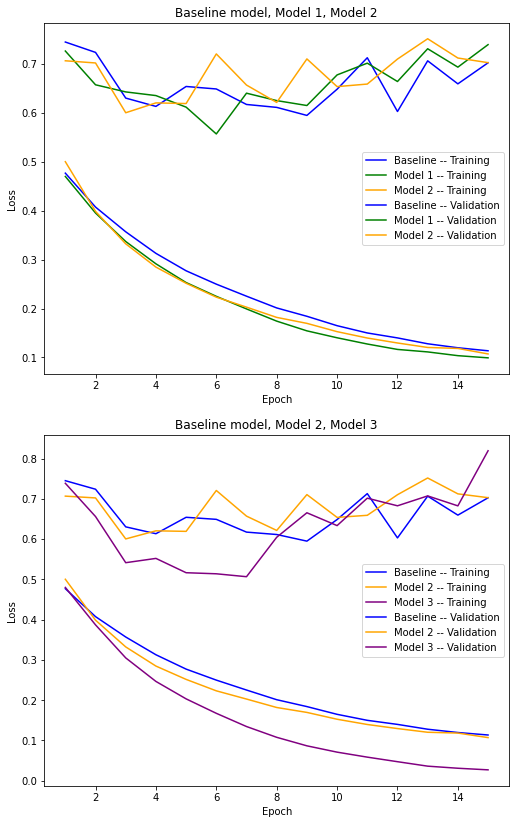

In [8]:
fig, ax = plt.subplots(2, 1,figsize=(8,12))
fig.tight_layout(pad = 4.0)

x = range(1,16)

ax[0].plot(x, train_loss_list, color='blue', label = 'Baseline -- Training')
ax[0].plot(x, train_loss_list1, color='green', label = 'Model 1 -- Training')
ax[0].plot(x, train_loss_list2, color='orange', label = 'Model 2 -- Training')
ax[0].plot(x, valid_loss_list, color='blue', label = 'Baseline -- Validation')
ax[0].plot(x, valid_loss_list1, color='green', label = 'Model 1 -- Validation')
ax[0].plot(x, valid_loss_list2, color='orange', label = 'Model 2 -- Validation')
ax[0].set_title('Baseline model, Model 1, Model 2')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend()

ax[1].plot(x, train_loss_list, color='blue', label = 'Baseline -- Training')
ax[1].plot(x, train_loss_list2, color='orange', label = 'Model 2 -- Training')
ax[1].plot(x, train_loss_list3, color='purple', label = 'Model 3 -- Training')
ax[1].plot(x, valid_loss_list, color='blue', label = 'Baseline -- Validation')
ax[1].plot(x, valid_loss_list2, color='orange', label = 'Model 2 -- Validation')
ax[1].plot(x, valid_loss_list3, color='purple', label = 'Model 3 -- Validation')
ax[1].set_title('Baseline model, Model 2, Model 3')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()

### 4.3.5 Improving Model Training

In this part, you will explore some common techniques to improve your model performance. You are required to implement two of the four categories (A-D). (If you have implemented more than two categories, only the two with the highest marks will be counted towards the final score.) Except for the settings mentioned in the following questions, all other model configurations and training settings should be the same as those for model 2. For the loss curve plotting and validation accuracy comparison in this part, you may reuse the results and curves of model 2 in Q5. For the code implementation, you may duplicate your previous code and modify it from there. Alternatively, you may also modify your previous code to accept new arguments for different configurations. Make sure that your changes are clearly indicated by appropriate comments in the code.

#### A. Pre-trained Word Embedding
Pre-trained word embeddings are the trained weights of the embedding layer from large datasets. They can capture the semantic and syntactic information of words, and be used as the initial weights of the embedding layer for solving other tasks. In this task, you are required to use the GloVe pre-trained word embedding for your model. Specifically, you should load the glove.6B.50d word embedding in torchtext and implement two models, one with a fixed pretrained GloVe embedding (model 4) and the other with a GloVe embedding fine-tuned for this dataset (model 5). To verify the effectiveness of the word embedding, you should also implement a model with random vectors as word embedding (model 6) (i.e., a randomly initialized non-trainable embedding). A summary of the three models is shown in Table 4.

**[Q7a]** Report the L2 distances of the pre-trained GloVe embedding for the three word pairs below. What can you observe?
• ‘happy’ and ‘good’
• ‘france’ and ‘germany’
• ‘france’ and ‘happy’

In [9]:
def load_glove_weights(glove_fpath, n_vocab, embedding_dim, word_index):
    embeddings_index = {}
    with open(glove_fpath, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings_index[word] = vector

    embedding_matrix = np.zeros((n_vocab, embedding_dim))
    found_ct = 0
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            found_ct += 1
    return embedding_matrix

vocabs = ['happy', 'good', 'france', 'germany']
word_index = {w: i for i, w in enumerate(vocabs)}

# download the dict from https://nlp.stanford.edu/projects/glove/
g_weights = load_glove_weights('./glove.6B.50d.txt', txt_field.vocab.__len__(), embedding_dim=50, word_index=word_index)

# "happy" and "good"
l2dist = np.linalg.norm(g_weights[0]-g_weights[1])
print("L2 distance between \"happy\" and \"good\": {:.4f}".format(l2dist))
# "france" and "germany"
l2dist = np.linalg.norm(g_weights[2]-g_weights[3])
print("L2 distance between \"france\" and \"germany\": {:.4f}".format(l2dist))
# "france" and "happy"
l2dist = np.linalg.norm(g_weights[2]-g_weights[0])
print("L2 distance between \"france\" and \"happy\": {:.4f}".format(l2dist))

L2 distance between "happy" and "good": 2.7146
L2 distance between "france" and "germany": 3.9774
L2 distance between "france" and "happy": 6.3060


**[Q8a]** Before training, among model 2, model 4, model 5, and model 6, which one do you expect to have the best performance and which one has the worst? Why?

**[Q9a]** Plot the training and validation losses of model 2, model 4, model 5, and model 6 in one plot and report the best validation accuracy of each model. Does the result follow your expectation? If not, suggest some possible reason(s).

In [10]:
class Text_RNN_Var4(nn.Module):
    def __init__(self, pre_embd, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Text_RNN_Var4, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim, padding_idx=0)
        self.emb.weight = nn.Parameter(pre_embd, requires_grad=False) # freeze parameters
        self.rnn = nn.LSTM(                              # LSTM, non-bi-directional
                input_size = embedding_dim,
                hidden_size = n_hidden,
                num_layers = n_layers,
                batch_first = True,
                dropout = dropout,
                bidirectional = False
        )
        self.linear = nn.Linear(n_hidden, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, txt, txt_len):
        txt_emb = self.emb(txt)  
        packed_embedded = nn.utils.rnn.pack_padded_sequence(txt_emb, txt_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        output = self.sigmoid(self.linear(outputs))
        output = torch.mean(output, 1)
        return output

class Text_RNN_Var5(nn.Module):
    def __init__(self, pre_embd, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Text_RNN_Var5, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim, padding_idx=0)
        self.emb.weight = nn.Parameter(pre_embd, requires_grad=True) # unfreeze parameters
        self.rnn = nn.LSTM(                              # LSTM, non-bi-directional
                input_size = embedding_dim,
                hidden_size = n_hidden,
                num_layers = n_layers,
                batch_first = True,
                dropout = dropout,
                bidirectional = False
        )
        self.linear = nn.Linear(n_hidden, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, txt, txt_len):
        txt_emb = self.emb(txt)  
        packed_embedded = nn.utils.rnn.pack_padded_sequence(txt_emb, txt_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        output = self.sigmoid(self.linear(outputs))
        output = torch.mean(output, 1)
        return output

class Text_RNN_Var6(nn.Module):
    def __init__(self, pre_embd, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Text_RNN_Var6, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim, padding_idx=0)
        self.emb.weight = nn.Parameter(pre_embd, requires_grad=True) # freeze parameters
        self.rnn = nn.LSTM(                              # LSTM, non-bi-directional
                input_size = embedding_dim,
                hidden_size = n_hidden,
                num_layers = n_layers,
                batch_first = True,
                dropout = dropout,
                bidirectional = False
        )
        self.linear = nn.Linear(n_hidden, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, txt, txt_len):
        txt_emb = self.emb(txt)  
        packed_embedded = nn.utils.rnn.pack_padded_sequence(txt_emb, txt_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        output = self.sigmoid(self.linear(outputs))
        output = torch.mean(output, 1)
        return output


glove_embd = torch.from_numpy(g_weights).type(torch.FloatTensor)

model4 = Text_RNN_Var4(glove_embd, txt_field.vocab.__len__(), embedding_dim=50, n_hidden=64, n_layers=1, dropout=.1)
model5 = Text_RNN_Var5(glove_embd, txt_field.vocab.__len__(), embedding_dim=50, n_hidden=64, n_layers=1, dropout=.1)
model6 = Text_RNN_Var6(torch.rand(glove_embd.shape), txt_field.vocab.__len__(), embedding_dim=50, n_hidden=64, n_layers=1, dropout=.1)

n_epochs = 15
val_acc = None
criterion = nn.BCELoss()

print("Training Model 4 (GloVe embedding, froze parameters):")
save_name = 'rnn_model4'
optimizer = Adam(model4.parameters())
train_loss_list4, valid_loss_list4 = TRAIN(model4, train_iter, valid_iter,  n_epochs, criterion, optimizer, val_acc, device, save_name)

print("\n\nTraining Model 5 (GloVe embedding):")
save_name = 'rnn_model5'
optimizer = Adam(model5.parameters())
train_loss_list5, valid_loss_list5 = TRAIN(model5, train_iter, valid_iter,  n_epochs, criterion, optimizer, val_acc, device, save_name)

print("\n\nTraining Model 6 (Random vector embedding):")
save_name = 'rnn_model6'
optimizer = Adam(model6.parameters())
train_loss_list6, valid_loss_list6 = TRAIN(model6, train_iter, valid_iter,  n_epochs, criterion, optimizer, val_acc, device, save_name)

Training Model 4 (GloVe embedding, froze parameters):
Epoch [1/15], Train Loss: 0.5064, Valid Loss: 0.7813, Valid Accuracy: 0.5005
Model saved to rnn_model4
Epoch [2/15], Train Loss: 0.4415, Valid Loss: 0.7663, Valid Accuracy: 0.5485
Model saved to rnn_model4
Epoch [3/15], Train Loss: 0.4310, Valid Loss: 0.8064, Valid Accuracy: 0.5465
Epoch [4/15], Train Loss: 0.4271, Valid Loss: 0.7928, Valid Accuracy: 0.5540
Model saved to rnn_model4
Epoch [5/15], Train Loss: 0.4267, Valid Loss: 0.8097, Valid Accuracy: 0.5455
Epoch [6/15], Train Loss: 0.4263, Valid Loss: 0.7644, Valid Accuracy: 0.5630
Model saved to rnn_model4
Epoch [7/15], Train Loss: 0.4265, Valid Loss: 0.7665, Valid Accuracy: 0.5645
Model saved to rnn_model4
Epoch [8/15], Train Loss: 0.4250, Valid Loss: 0.7776, Valid Accuracy: 0.5625
Epoch [9/15], Train Loss: 0.4247, Valid Loss: 0.7699, Valid Accuracy: 0.5565
Epoch [10/15], Train Loss: 0.4243, Valid Loss: 0.7668, Valid Accuracy: 0.5665
Model saved to rnn_model4
Epoch [11/15], Trai

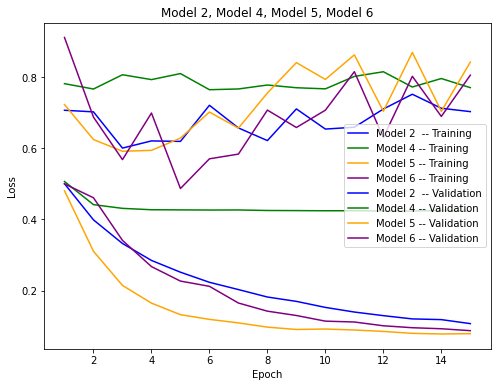

In [11]:
x = range(1,16)

plt.figure(figsize=(8, 6))

plt.plot(x, train_loss_list2, color='blue', label = 'Model 2  -- Training')
plt.plot(x, train_loss_list4, color='green', label = 'Model 4 -- Training')
plt.plot(x, train_loss_list5, color='orange', label = 'Model 5 -- Training')
plt.plot(x, train_loss_list6, color='purple', label = 'Model 6 -- Training')
plt.plot(x, valid_loss_list2, color='blue', label = 'Model 2  -- Validation')
plt.plot(x, valid_loss_list4, color='green', label = 'Model 4 -- Validation')
plt.plot(x, valid_loss_list5, color='orange', label = 'Model 5 -- Validation')
plt.plot(x, valid_loss_list6, color='purple', label = 'Model 6 -- Validation')
plt.title('Model 2, Model 4, Model 5, Model 6')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

#### B. Model Weight Initialization

In this task, you will implement two weight initialization methods, Xavier and Kaiming. Both methods should use the normal distribution.

**[Q7b]** What is weight initialization? What potential problem is it trying to prevent from happening? Explain it briefly.

**[Q8b]** Plot the training and validation losses of model 2, model 7, and model 8 in one plot and report the best validation accuracy of each model.

**[Q9b]** From the above results, does weight initialization affect model training in terms of convergence rate and model performance in terms of validation accuracy? If yes, describe the difference(s). If no, suggest some possible reason(s).

In [12]:
class Text_RNN_Var7(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Text_RNN_Var7, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim) 
        nn.init.xavier_normal_(self.emb.weight)          # Xavier initialization on embedding layer
        
        self.rnn = nn.LSTM(                              # LSTM, non-bi-directional
                input_size = embedding_dim,
                hidden_size = n_hidden,
                num_layers = n_layers,
                batch_first = True,
                dropout = dropout,
                bidirectional = False
        )
        nn.init.xavier_normal_(self.rnn.weight_ih_l0)    # Xavier initialization on rnn layer
        nn.init.xavier_normal_(self.rnn.weight_hh_l0)
        #nn.init.zeros_(self.rnn.bias_ih_l0)
        #nn.init.zeros_(self.rnn.bias_hh_l0)
        self.linear = nn.Linear(n_hidden, 1)
        nn.init.xavier_normal_(self.linear.weight)       # Xavier initialization on fully-connected layer
        #nn.init.zeros_(self.linear.bias)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, txt, txt_len):
        txt_emb = self.emb(txt)  
        packed_embedded = nn.utils.rnn.pack_padded_sequence(txt_emb, txt_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        output = self.sigmoid(self.linear(outputs))
        output = torch.mean(output, 1)
        return output
    
class Text_RNN_Var8(nn.Module):
    def __init__(self, n_vocab, embedding_dim, n_hidden, n_layers, dropout):
        super(Text_RNN_Var8, self).__init__()
        self.emb = nn.Embedding(n_vocab, embedding_dim) 
        nn.init.xavier_normal_(self.emb.weight)           # Kaiming initialization on embedding layer
        self.rnn = nn.LSTM(                               # LSTM, non-bi-directional
                input_size = embedding_dim,
                hidden_size = n_hidden,
                num_layers = n_layers,
                batch_first = True,
                dropout = dropout,
                bidirectional = False
        )
        nn.init.kaiming_normal_(self.rnn.weight_ih_l0)    # Kaiming initialization on rnn layer
        nn.init.kaiming_normal_(self.rnn.weight_hh_l0)
        #nn.init.zeros_(self.rnn.bias_ih_l0)
        #nn.init.zeros_(self.rnn.bias_hh_l0)
        self.linear = nn.Linear(n_hidden, 1)
        nn.init.xavier_normal_(self.linear.weight)        # Kaiming initialization on fully-connected layer
        #nn.init.zeros_(self.linear.bias)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, txt, txt_len):
        txt_emb = self.emb(txt)  
        packed_embedded = nn.utils.rnn.pack_padded_sequence(txt_emb, txt_len, batch_first=True)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        output = self.sigmoid(self.linear(outputs))
        output = torch.mean(output, 1)
        return output

model7 = Text_RNN_Var7(txt_field.vocab.__len__(), embedding_dim=50, n_hidden=64, n_layers=1, dropout=.1).cuda()
model8 = Text_RNN_Var8(txt_field.vocab.__len__(), embedding_dim=50, n_hidden=64, n_layers=1, dropout=.1).cuda()

n_epochs = 15
val_acc = None
criterion = nn.BCELoss()

print("Training Model 7 (Xavier initialization):")
save_name = 'rnn_model7'
optimizer = Adam(model7.parameters())
train_loss_list7, valid_loss_list7 = TRAIN(model7, train_iter, valid_iter,  n_epochs, criterion, optimizer, val_acc, device, save_name)

print("\n\nTraining Model 8 (Kaiming initialization):")
save_name = 'rnn_model8'
optimizer = Adam(model8.parameters())
train_loss_list8, valid_loss_list8 = TRAIN(model8, train_iter, valid_iter,  n_epochs, criterion, optimizer, val_acc, device, save_name)

Training Model 7 (Xavier initialization):
Epoch [1/15], Train Loss: 0.4699, Valid Loss: 0.6088, Valid Accuracy: 0.6530
Model saved to rnn_model7
Epoch [2/15], Train Loss: 0.2572, Valid Loss: 0.5572, Valid Accuracy: 0.7310
Model saved to rnn_model7
Epoch [3/15], Train Loss: 0.1771, Valid Loss: 0.5815, Valid Accuracy: 0.7410
Model saved to rnn_model7
Epoch [4/15], Train Loss: 0.1470, Valid Loss: 0.6613, Valid Accuracy: 0.7245
Epoch [5/15], Train Loss: 0.1240, Valid Loss: 0.6416, Valid Accuracy: 0.7340
Epoch [6/15], Train Loss: 0.1117, Valid Loss: 0.7023, Valid Accuracy: 0.7380
Epoch [7/15], Train Loss: 0.0986, Valid Loss: 0.6531, Valid Accuracy: 0.7465
Model saved to rnn_model7
Epoch [8/15], Train Loss: 0.0960, Valid Loss: 0.7232, Valid Accuracy: 0.7300
Epoch [9/15], Train Loss: 0.0946, Valid Loss: 0.7288, Valid Accuracy: 0.7360
Epoch [10/15], Train Loss: 0.0926, Valid Loss: 0.7668, Valid Accuracy: 0.7310
Epoch [11/15], Train Loss: 0.0874, Valid Loss: 0.9027, Valid Accuracy: 0.7125
Epoch

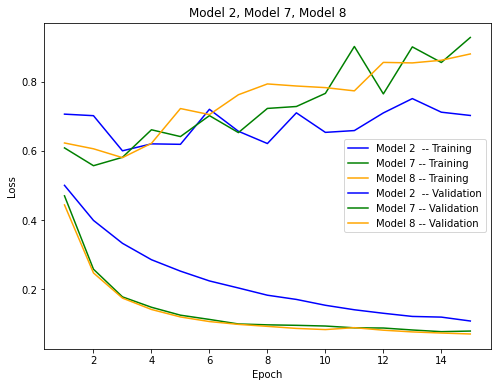

In [13]:
x = range(1,16)

plt.figure(figsize=(8, 6))

plt.plot(x, train_loss_list2, color='blue', label = 'Model 2  -- Training')
plt.plot(x, train_loss_list7, color='green', label = 'Model 7 -- Training')
plt.plot(x, train_loss_list8, color='orange', label = 'Model 8 -- Training')
plt.plot(x, valid_loss_list2, color='blue', label = 'Model 2  -- Validation')
plt.plot(x, valid_loss_list7, color='green', label = 'Model 7 -- Validation')
plt.plot(x, valid_loss_list8, color='orange', label = 'Model 8 -- Validation')
plt.title('Model 2, Model 7, Model 8')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

#### D. Model Ensemble
Model ensemble is a method of combining a diverse set of learners (individual models) together to improve the stability and predictive power of the model. In this task, you will implement two common ensemble methods, average ensemble and weighted average ensemble. To be specific, the average ensemble averages the predicted probabilities of the three best models (in terms of validation accuracy) from your previous implemented models to make a final prediction
(Figure 1), while the weighted average ensemble assigns specific weights to the models.

**[Q7d]** Why does the model ensemble improve the performance of the model?

**[Q8d]** Propose a method to find suitable weights for the models in the weighted average ensemble. Explain your method.

**[Q9d]** Compare the validation accuracy of these five models (three chosen models and two ensemble models). Do the ensemble methods improve the model performance (in terms of validation accuracy)? If yes, describe the difference(s). If no, suggest some possible reason(s).

In [16]:
model12 = Text_RNN_Var3(txt_field.vocab.__len__(), embedding_dim=50, n_hidden=64, n_layers=1, dropout=.1).cuda()
model13 = Text_RNN(txt_field.vocab.__len__(), embedding_dim=50, n_hidden=64, n_layers=1, dropout=.1).cuda()
model14 = Text_RNN_Var5(glove_embd, txt_field.vocab.__len__(), embedding_dim=50, n_hidden=64, n_layers=1, dropout=.1).cuda()

optimizer = Adam(model12.parameters())
valid_acc12 = load_checkpoint('rnn_model3', model12, optimizer)
optimizer = Adam(model13.parameters())
valid_acc13 = load_checkpoint('rnn_model', model13, optimizer)
optimizer = Adam(model14.parameters())
valid_acc14 = load_checkpoint('rnn_model5', model14, optimizer)

def find_weights(model_list):
    best_valid_acc = float('-inf')
    best_weights = []
    for weight1 in range(10):
        for weight2 in range(10):
            for weight3 in range(10):
                if (weight1 + weight2 + weight3 == 10):
                    running_corrects = 0
                    valid_iter2 = valid_iter
                    for i, batch in enumerate(valid_iter):
                        text, text_len = batch.text
                        output1 = model_list[0](text, text_len.to('cpu'))
                        output2 = model_list[1](text, text_len.to('cpu'))
                        output3 = model_list[2](text, text_len.to('cpu'))
                        output = (output1*weight1 + output2*weight2 + output3*weight3)/10
                        labels = batch.label.unsqueeze(1).type(torch.FloatTensor).to(device)

                        preds = (output >= 0.5)
                        running_corrects += torch.sum(preds == labels.data)
                    valid_acc = running_corrects / float(len(valid_iter.dataset))
                    
                    if (valid_acc > best_valid_acc):
                        best_valid_acc = valid_acc
                        best_weights = [weight1, weight2, weight3]
    return best_weights
                    
class Text_RNN_Var15(nn.Module):
    def __init__(self, model1, model2, model3):
        super(Text_RNN_Var15, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        
    def forward(self, txt, txt_len):
        output1 = self.model1(txt, txt_len)
        output2 = self.model2(txt, txt_len)
        output3 = self.model3(txt, txt_len)
        output = (output1 + output2 + output3)/3
        return output
    
class Text_RNN_Var16(nn.Module):
    def __init__(self, model1, model2, model3):
        super(Text_RNN_Var16, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        
    def forward(self, txt, txt_len, weights):
        output1 = self.model1(text, text_len.to('cpu'))
        output2 = self.model2(text, text_len.to('cpu'))
        output3 = self.model3(text, text_len.to('cpu'))
        output = (output1*weights[0] + output2*weights[1] + output3*weights[2])/10
        return output

model15 = Text_RNN_Var15(model12, model13, model14)
model16 = Text_RNN_Var16(model12, model13, model14)

weights = find_weights([model12, model13, model14])

running_corrects15 = 0
running_corrects16 = 0
for i, batch in enumerate(valid_iter):
    text, text_len = batch.text
    output15 = model15(text, text_len.to('cpu'))
    output16 = model16(text, text_len.to('cpu'), weights)
    labels = batch.label.unsqueeze(1).type(torch.FloatTensor).to(device)
    
    preds15 = (output15 >= 0.5)
    preds16 = (output16 >= 0.5)
    running_corrects15 += torch.sum(preds15 == labels.data)
    running_corrects16 += torch.sum(preds16 == labels.data)
    
valid_acc15 = running_corrects15 / float(len(valid_iter.dataset))
valid_acc16 = running_corrects16 / float(len(valid_iter.dataset))

print("Validation Accuracy of model 15 (Average Emsemble): {:.4f}".format(valid_acc15))
print("Validation Accuracy of model 16 (Weighted Average Emsemble): {:.4f}".format(valid_acc16))

Model loaded from rnn_model3, with val accuracy: 0.7915000319480896
Model loaded from rnn_model, with val accuracy: 0.753000020980835
Model loaded from rnn_model5, with val accuracy: 0.752500057220459
Validation Accuracy of model 15 (Average Emsemble): 0.7825
Validation Accuracy of model 16 (Weighted Average Emsemble): 0.7975


### 4.3.6 Prediction
In the prediction stage, choose the model (possibly a model ensemble) with the highest validation accuracy and predict the labels of the news in test.csv. (You can simply load the saved model checkpoint. You do not need to retrain the model on both the training and validation sets.) Save the predictions as a csv file. The score for this task is based on your prediction accuracy.

**[P1]** Submit your predictions as pred.csv. The file should consist of two columns, where the first column is the predicted label and the second column is the news text. (The row order should be the same as that in test.csv.)

In [56]:
test_df = pd.read_csv('./test.csv', sep=',')
index = range(0,2000)
test_df['index'] = index
test_df.to_csv('test_df.csv',index=False)

index_field = Field(sequential=False, use_vocab=False, batch_first=True)
test = TabularDataset(path = PATH + 'test_df.csv', format='csv', fields=[('label', label_field), ('text', txt_field), ('index', index_field)], skip_header=True)

test_iter = BucketIterator(test, batch_size=64, sort_key=lambda x:len(x.text), sort_within_batch=True, device=device)

In [57]:
text_list = test_df['text'].tolist

for i, batch in enumerate(test_iter):
    text, text_len = batch.text
    output = model16(text, text_len.to('cpu'), weights)
    preds = (output >= 0.5)
    indexes = batch.index.to('cpu')
    
    for i, index in enumerate(indexes):
        index = index.item()
        test_df.loc[index,'label'] = int(preds[i].item())

test_df.drop(['index'], axis=1, inplace=True)
test_df.to_csv('20599045_pred.csv',index=False)